In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from keras import models, layers, optimizers, callbacks
from keras.callbacks import History

from typing import Generator

In [3]:
def weather_data_generator(
        data: np.ndarray, 
        lookback: int, 
        delay: int, 
        min_index: int, 
        max_index: int,
        shuffle: bool = False, 
        batch_size: int = 128, 
        step: int = 6
    ):
    """
    A generator function to yield batches of time series data and their corresponding targets.

    Args:
    - data (numpy.ndarray): The dataset from which samples and targets will be generated. It is expected to be a 2D array where rows represent time steps and columns represent different features.
    - lookback (int): The number of previous time steps to consider for each sample. This defines the window size of the past observations to use as input features.
    - delay (int): The number of time steps in the future to predict. The target for each sample will be the value at the current time step plus this delay.
    - min_index (int): The starting index in the dataset from which to start taking samples.
    - max_index (int): The ending index in the dataset up to which samples can be taken. If None, it defaults to the end of the data minus the delay.
    - shuffle (bool, optional): Whether to shuffle the samples or draw them in chronological order.
    - batch_size (int, optional): The number of samples per batch.
    - step (int, optional): The period, in terms of time steps, between successive samples within the lookback window. It determines the sampling frequency within the lookback window.

    Yields:
    - tuple: A tuple containing:
        - samples (np.ndarray): A 3D numpy array of shape (batch_size, lookback // step, data.shape[-1]), containing the input features.
        - targets (np.ndarray): A 1D numpy array of shape (batch_size,), containing the target values.
    """
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

def plot_loss(history: History) -> plt.Figure:
    '''
    Creates and returns figure with the plot of train and validation loss.

    Args:
    - history (keras.src.callbacks.history.History): A history object returned from the fit method of a Keras model.
    
    Returns:
    - matplotlib.figure.Figure: The matplotlib figure object containing the plot.
    '''
    fig, ax = plt.subplots()

    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')

    ax.set_xticks(range(0, len(history.history['loss']) + 1))
    ax.set_title('Training VS Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

    plt.tight_layout()
    plt.close(fig)  # To prevent double visualization

    return fig

def evaluate_naive_method(gen: Generator, steps: int) -> int:
    """
    A function to evaluate a common sense baseline method for time series forecasting.

    The naive method uses the last observed value in the input sequence as the prediction for the target value. 
    This function calculates the Mean Absolute Error (MAE) of this naive method over a series of validation steps.

    Args:
    - gen (Generator): A generator that yields batches of samples and targets.
    - steps (int): The number of steps to iterate over the generator.

    Returns:
    - int: The mean MAE over all steps.

    Notes:
    - The generator 'gen' is expected to be generator returned by 'weather_data_generator' function.
    """
    batch_maes = []
    for step in range(steps):
        samples, targets = next(gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    return np.mean(batch_maes)


## Data preparation

In [4]:
# Replace this with the actual path to Jena Climate Dataset
dataset_path = '/Users/martinmurzenkov/Programming/portfolio/data/jena_climate_2009_2016.csv'
df = pd.read_csv(dataset_path)

# Initially Data Time contains string values
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')

df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
# Make data suitable for the model
float_data = df.drop(columns=['Date Time']).to_numpy(dtype=float)

# Normalize data based on training set only
float_data -= float_data[:200000].mean(axis=0)
float_data /= float_data[:200000].std(axis=0)

# Set parameters
lookback = 1440  # Number of past timestamps
step = 6  # Period between successive timesteps 
delay = 144  # Number of timesteps in the future to predict
batch_size = 128

val_steps = (300_000 - 200_001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [6]:
train_gen = weather_data_generator(float_data, lookback, delay, 0, 200_000, False, batch_size, step)
val_gen = weather_data_generator(float_data, lookback, delay, 200_001, 300_000, False, batch_size, step)
test_gen = weather_data_generator(float_data, lookback, delay, 300_001, None, False, batch_size, step)

In [7]:
print(f'Train generator shape: {next(train_gen)[0].shape}, {next(train_gen)[1].shape}')
print(f'Validation generator shape: {next(val_gen)[0].shape}, {next(val_gen)[1].shape}')
print(f'Test generator shape: {next(test_gen)[0].shape}, {next(test_gen)[1].shape}')

Train generator shape: (128, 240, 14), (128,)
Validation generator shape: (128, 240, 14), (128,)
Test generator shape: (128, 240, 14), (128,)


In [8]:
# Calculate Common Sense Baseline
evaluate_naive_method(val_gen, val_steps)

0.28973597299054815

## Model creation, training and evaluation

In [16]:
model = models.Sequential([
    layers.Input(shape = (lookback//step, float_data.shape[-1])),
    layers.LSTM(32),
    layers.Dense(1)
])

model.compile(optimizer=optimizers.RMSprop(), loss='mse')

# To stop training when we start overfitting and restore best weights.
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_gen,
    steps_per_epoch=500, 
    epochs=50, 
    validation_data=val_gen, 
    validation_steps=val_steps,
    callbacks=[early_stopping]
)

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 133s 264ms/step - loss: 0.2184 - val_loss: 0.3744
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 158s 315ms/step - loss: 0.1825 - val_loss: 0.2482
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 160s 321ms/step - loss: 0.1787 - val_loss: 0.2336
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 146s 293ms/step - loss: 0.1264 - val_loss: 0.2266
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 161s 321ms/step - loss: 0.1417 - val_loss: 0.2664
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 166s 331ms/step - loss: 0.1384 - val_loss: 0.2294
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 164s 329ms/step - loss: 0.1172 - val_loss: 0.2062
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 184s 368ms/step - loss: 0.1223 - val_loss: 0.2254
Epoch 9/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 168s 336ms/step - loss: 0.1304 - val_loss: 0.1796
Epoch 10/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 173s 346ms/step - loss: 0.1199 - val_loss: 0.1705
Epoch 11/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 171s 343ms/step - loss: 0.1247 - val_loss: 0.2151
Epoch 12

In [17]:
# Performance on validation data
model.evaluate(val_gen, steps=val_steps)

769/769 ━━━━━━━━━━━━━━━━━━━━ 81s 105ms/step - loss: 0.1250


0.13728947937488556

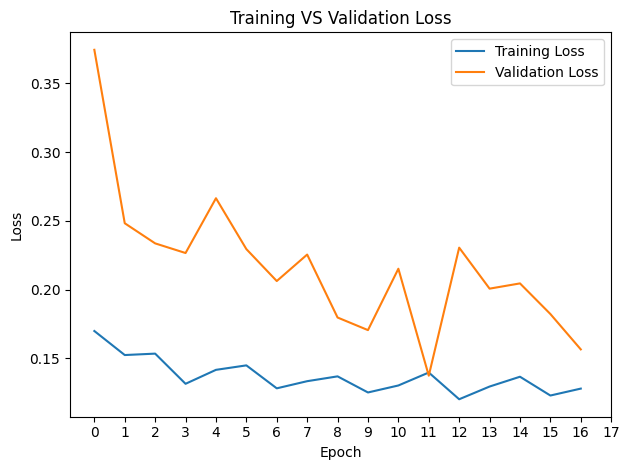

In [24]:
plot_loss(history)

In [18]:
# Performance on test data
model.evaluate(test_gen, steps=test_steps)

930/930 ━━━━━━━━━━━━━━━━━━━━ 82s 88ms/step - loss: 0.1509


0.15146130323410034

## Predictions visualization

In [45]:
prediction = next(test_gen)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


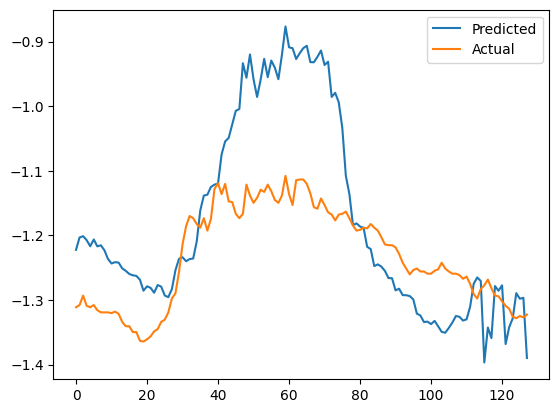

In [46]:
plt.plot(model.predict(prediction[0]), label='Predicted')
plt.plot(prediction[1], label='Actual')
plt.legend()

## Save model

In [47]:
model.save('/Users/martinmurzenkov/Programming/portfolio/neural-networks/jena_climate/jena_climate.h5')